# Bar Buddy

### There are thousands of cocktails in the world, all containing unique flavors and ingredients. Is there a better way to figure out what alcoholic beverages you like than trial & error?
**This notebook will help in answering questions like:**
- Which drinks are most similar to ones I already know I like?
- Which attributes determine the drinks that I like?

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib
import matplotlib.pyplot as plt

## Cocktail Dataset
[This dataset](https://www.kaggle.com/jenlooper/mr-boston-cocktail-dataset/) contains data on almost 1000 unique cocktails. Each row represents a specific cocktail and the features represent the specific ingredients and amounts of each ingredient. It also contains insctructions for making each cocktail.

In [2]:
cocktails_df = pd.read_csv('mr-boston-flattened.csv')

In [3]:
cocktails_df.head()

,name,category,measurement-1,ingredient-1,measurement-2,ingredient-2,measurement-3,ingredient-3,measurement-4,ingredient-4,measurement-5,ingredient-5,measurement-6,ingredient-6,instructions,glass,glass-size
0,Gauguin,Cocktail Classics,2 oz,Light Rum,1 oz,Passion Fruit Syrup,1 oz,Lemon Juice,1 oz,Lime Juice,NaN,NaN,NaN,NaN,Combine ingredients with a cup of crushed ice ...,Old-Fashioned Glass,6 to 8 ounces
1,Fort Lauderdale,Cocktail Classics,1 1/2 oz,Light Rum,1/2 oz,Sweet Vermouth,1/4 oz,Juice of Orange,1/4 oz,Juice of a Lime,NaN,NaN,NaN,NaN,Shake with ice and strain into old-fashioned g...,Old-Fashioned Glass,6 to 8 ounces
2,Apple Pie,Cordials and Liqueurs,3 oz,Apple schnapps,1 oz,Cinnamon schnapps,NaN,Apple slice,NaN,NaN,NaN,NaN,NaN,NaN,Pour into ice-filled old-fashioned glass. Garn...,Old-Fashioned Glass,6 to 8 ounces
3,Cuban Cocktail No. 1,Cocktail Classics,1/2 oz,Juice of a Lime,1/2 oz,Powdered Sugar,2 oz,Light Rum,NaN,NaN,NaN,NaN,NaN,NaN,Shake with ice and strain into cocktail glass.,Cocktail Glass,6 or more ounces
4,Cool Carlos,Cocktail Classics,1 1/2 oz,Dark rum,2 oz,Cranberry Juice,2 oz,Pineapple Juice,1 oz,Orange curacao,1 oz,Sour Mix,NaN,NaN,"Mix all ingredients except curacao with ice, s...",Collins Glass,14 to 16 ounces


In [4]:
#Analyze unique values of ingredients
cocktails_df['ingredient-1'].unique()[:20]
#Noticing a lot of specific types of liquor(ie. Irish Whiskey) and branded ingredients(Old Mr.Boston)
#Will need to generalize those

array([' Light Rum', ' Apple schnapps', ' Juice of a Lime', ' Dark rum',
       ' Bourbon whiskey', ' Amaretto', ' Scotch Whiskey', ' Bacardi Rum',
       ' Brandy', ' Gin', ' Sloe gin', ' Sweet Vermouth',
       ' Tanqueray gin', ' Lemon Juice', ' Straight rye whiskey',
       ' Grenadine', ' Green Chartreuse', ' Irish Whiskey',
       ' Dry Vermouth', ' Juice of a Lemon'], dtype=object)

## Model Dataset Creation

In order to leverage the available dataset, we need to create a DataFrame indexed by the cocktail names with each ingredient/flavor as a binary feature.

In [5]:
#dropping unnecessary columns for constructing new dataset
cocktail_ingredients = cocktails_df.drop(columns=['category', 'measurement-1', 'measurement-2', 'measurement-3', 'measurement-4', 'measurement-5', 'measurement-6', 'instructions', 'glass', 'glass-size'])
cocktail_ingredients = cocktail_ingredients.fillna('none')
cocktail_ingredients.head()

,name,ingredient-1,ingredient-2,ingredient-3,ingredient-4,ingredient-5,ingredient-6
0,Gauguin,Light Rum,Passion Fruit Syrup,Lemon Juice,Lime Juice,none,none
1,Fort Lauderdale,Light Rum,Sweet Vermouth,Juice of Orange,Juice of a Lime,none,none
2,Apple Pie,Apple schnapps,Cinnamon schnapps,Apple slice,none,none,none
3,Cuban Cocktail No. 1,Juice of a Lime,Powdered Sugar,Light Rum,none,none,none
4,Cool Carlos,Dark rum,Cranberry Juice,Pineapple Juice,Orange curacao,Sour Mix,none


In [6]:
#Concatenate each cocktail into a list of ingredients 
cocktail_ingredients['ingredients_list'] = cocktail_ingredients[['ingredient-1', 'ingredient-2', 'ingredient-3', 'ingredient-4', 'ingredient-5', 'ingredient-6']].values.tolist()

def format(lst):
  lower = [i.lower() for i in lst]
  space = [i.replace(" ", "_") for i in lower]
  temp = np.concatenate([i.split(',') for i in space])
  splitt = np.concatenate([i.split(';') for i in temp])
  return [i + "_" for i in splitt]

cocktail_ingredients['ingredients_list'] = cocktail_ingredients['ingredients_list'].apply(format)
cocktail_ingredients.head(20)

,name,ingredient-1,ingredient-2,ingredient-3,ingredient-4,ingredient-5,ingredient-6,ingredients_list
0,Gauguin,Light Rum,Passion Fruit Syrup,Lemon Juice,Lime Juice,none,none,"[_light_rum_, _passion_fruit_syrup_, _lemon_ju..."
1,Fort Lauderdale,Light Rum,Sweet Vermouth,Juice of Orange,Juice of a Lime,none,none,"[_light_rum_, _sweet_vermouth_, _juice_of_oran..."
2,Apple Pie,Apple schnapps,Cinnamon schnapps,Apple slice,none,none,none,"[_apple_schnapps_, _cinnamon_schnapps_, _apple..."
3,Cuban Cocktail No. 1,Juice of a Lime,Powdered Sugar,Light Rum,none,none,none,"[_juice_of_a_lime_, _powdered_sugar_, _light_r..."
4,Cool Carlos,Dark rum,Cranberry Juice,Pineapple Juice,Orange curacao,Sour Mix,none,"[_dark_rum_, _cranberry_juice_, _pineapple_jui..."
5,John Collins,Bourbon whiskey,Fresh lemon juice,Simple Syrup,Soda water,"Orange and lemon wheels, maraschino cherry",none,"[_bourbon_whiskey_, _fresh_lemon_juice_, _simp..."
6,Cherry Rum,Light Rum,cherry-flavored brandy,Light cream,none,none,none,"[_light_rum_, _cherry-flavored_brandy_, _light..."
7,Casa Blanca,Light Rum,Lime Juice,Triple Sec,Maraschino,none,none,"[_light_rum_, _lime_juice_, _triple_sec_, _mar..."
8,Caribbean Champagne,Light Rum,Creme de banana,Chilled Champagne,none,none,none,"[_light_rum_, _creme_de_banana_, chilled_champ..."
9,Amber Amour,Amaretto,Fresh lemon juice,Simple Syrup,Soda water,none,none,"[_amaretto_, _fresh_lemon_juice_, _simple_syru..."


In [7]:
#Create list of all unique ingredients 
all_ingredients = np.unique(np.concatenate([cocktail_ingredients['ingredient-1'].dropna(),cocktail_ingredients['ingredient-2'].dropna(),cocktail_ingredients['ingredient-3'].dropna(),cocktail_ingredients['ingredient-4'].dropna(),cocktail_ingredients['ingredient-5'].dropna(),cocktail_ingredients['ingredient-6'].dropna()]))
all_ingredients[:10]
#split all strings containing commas
all_ingredients = np.unique(np.concatenate([i.split(',') for i in all_ingredients]))
all_ingredients[:30]

array(['  Long', '  Old Mr. Boston Triple Sec', '  Orange half-wheel',
       ' 1 lime wheel', ' 1 oz', ' 1/2 oz', ' 100-proof Vodka',
       ' 151-Proof Rum', ' 17-year-old J. Wray and Nephew Ltd. Rum',
       ' 2 peach slices', ' 3/4 oz', ' 7-Up', ' Absinthe',
       ' Absinthe Substitute', ' Absinthe or pastis',
       ' Acai berry flavored vodka', ' African rum', ' Agave nectar',
       ' Aged rhum agricole', ' Allspice liqueur (pimento dram)',
       ' Almond extract', ' Almond milk', ' Almond or orgeat syrup',
       ' Amaretto', ' Amaretto di Saronno', ' Amaro', ' Amaro Nonino',
       ' Amer Picon or Torani Amer', ' Amontillado sherry',
       ' Anejo tequila'], dtype='<U96')

In [8]:
ingredients = ['gin', 'vodka', 'whisky', 'tequila', 'rum', 'champagne', 'orange', 'lemon', 'lime', 'ginger', 'mint', 'red_wine', 'bitters', 'sugar', 'cloves', 'cola', 'pepper', 'carbonated_water',
               'egg', 'tea', 'cider', 'cucumber', 'apple', 'bourbon', 'absinthe', 'strawberry', 'raspberry', 'salt', 'vermouth', 'simple_syrup', 'pineapple', 'almond',
               'maple', 'cherry', 'ketchup', 'cinnamon', 'half-and-half', 'pomegranate', 'basil', 'olive', 'worcestershire', 'triple_sec', 'lillet_blanc', 'lillet_rouge', 'cranberry', 'sherry',
               'fruit', 'chartreuse', 'creme_de_cacao', 'milk', 'brandy', 'curacao', 'chocolate', 'whipped_cream', 'vanilla', 'grape', 'rose', 'tomato',
               'clam', 'pear', 'thyme', 'pickle', 'punch', 'chili', 'cotton_candy', 'sour', 'root_beer', 'rhubarb', 'ice_cream', 'horseradish', 'molasses',
               'peppermint', 'orgeat', 'creme_de_menthe', 'apricot', 'mountain_dew', 'mezcal', 'melon', 'maraschino', 'margarita', 'mango', 'manderine', 'lychee', 
               'sherbet', 'jalapeno', 'iced_tea', 'honey', 'cognac', 'nutmeg', 'sage', 'grenadine', 'cilantro', 'basil', 'carrot', 'celery', 'elderflower',
               'dubonnet', 'demerara', 'cynar', 'banana', 'violette', 'fraiche', 'peche', 'menthe', 'cassis', 'yvette', 'limoncello', 'coconut', 'coffee', 'green_tea', 'chai', 'espresso', 
               'cointreau', 'clementine', 'club_soda', 'passion_fruit', 'citrus', 'beer', 'butterscotch', 'agave', 'amaretto', 'allspice']

In [9]:
cocktails_final = pd.DataFrame(columns = np.concatenate([['cocktail'], np.unique(ingredients)]))
cocktails_final['cocktail'] = cocktail_ingredients['name']
cocktails_final

,cocktail,absinthe,agave,allspice,almond,amaretto,apple,apricot,banana,basil,...,tomato,triple_sec,vanilla,vermouth,violette,vodka,whipped_cream,whisky,worcestershire,yvette
0,Gauguin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fort Lauderdale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Apple Pie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cuban Cocktail No. 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cool Carlos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,Wallis Blue Cocktail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
986,Minnehaha Cocktail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
987,Wallick Cocktail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
988,Waikiki Beachcomber,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
for ingredient in cocktails_final.columns[1:]:
  vals = []
  x = 0
  for cocktail in cocktails_final['cocktail']:
    contains = False
    for ing in cocktail_ingredients[cocktail_ingredients['name']==cocktail]['ingredients_list'][x]:
      val = ingredient
      if val == 'gin':
        val = 'gin_'
      if val in ing:
        contains = True
    if contains:
      vals.append(1)
    else:
      vals.append(0)
    x = x + 1
  cocktails_final[ingredient] = vals

In [11]:
cocktails_final[cocktails_final['ginger']==1]

,cocktail,absinthe,agave,allspice,almond,amaretto,apple,apricot,banana,basil,...,tomato,triple_sec,vanilla,vermouth,violette,vodka,whipped_cream,whisky,worcestershire,yvette
38,Irish Whiskey Highball,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,Mamie's Sister,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,London Buck,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,Leap Frog Highball,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81,Horse's Neck (With A Kick),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87,Frankenjack Cocktail,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
88,Fog Horn,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
103,Bulldog Highball,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118,Highland Cooler,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141,Vodka Cooler,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
cocktails_final.describe()

,absinthe,agave,allspice,almond,amaretto,apple,apricot,banana,basil,beer,...,tomato,triple_sec,vanilla,vermouth,violette,vodka,whipped_cream,whisky,worcestershire,yvette
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.018182,0.011111,0.002020,0.009091,0.026263,0.107071,0.039394,0.007071,0.003030,0.010101,...,0.009091,0.127273,0.011111,0.172727,0.002020,0.168687,0.003030,0.019192,0.006061,0.003030
std,0.133676,0.104875,0.044924,0.094960,0.159996,0.309359,0.194629,0.083832,0.054992,0.100045,...,0.094960,0.333447,0.104875,0.378202,0.044924,0.374664,0.054992,0.137268,0.077653,0.054992
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
cocktails = cocktails_final.set_index('cocktail')

In [14]:
# Here is the final dataset we will use for modeling!
cocktails.head()

,absinthe,agave,allspice,almond,amaretto,apple,apricot,banana,basil,beer,...,tomato,triple_sec,vanilla,vermouth,violette,vodka,whipped_cream,whisky,worcestershire,yvette
cocktail,,,,,,,,,,,,,,,,,,,,,
Gauguin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fort Lauderdale,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Apple Pie,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cuban Cocktail No. 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cool Carlos,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Modeling
Now that we have our final dataset, we will use Kmeans clustering to create distinct cocktail groups based on their flavors and ingredients

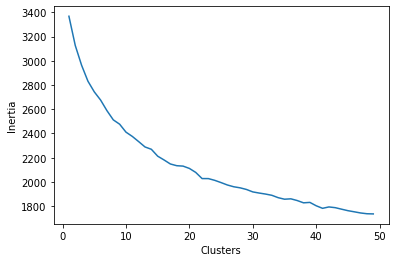

In [15]:
#use elbow method to find best k val
results = pd.DataFrame(data = {'clusters':np.arange(1,50,1)})
def inertia(clusters):
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    kmeans.fit(cocktails)
    return kmeans.inertia_
results['inertia'] = results['clusters'].apply(inertia)
plt.plot(results['clusters'], results['inertia'])
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()
#select 10

In [16]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(cocktails)
unique, counts = np.unique(kmeans.labels_, return_counts = True)
cocktail_clusters = cocktails
cocktail_clusters['cluster'] = kmeans.labels_
cocktail_clusters = cocktail_clusters[['cluster']]
dict(zip(unique, counts))

{0: 34, 1: 88, 2: 152, 3: 133, 4: 134, 5: 91, 6: 57, 7: 118, 8: 80, 9: 103}

## Visualization & Application Processing
Now that we have created our clusters, we will conduct some final data processing to transform the data for visualization and application.

In [17]:
#reduce dimensionality using TSNE for visualization purposes
from sklearn.manifold import TSNE
cocktail_vectors = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(cocktails)
cocktail_vectors

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 990 samples in 0.000s...
[t-SNE] Computed neighbors for 990 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 990 / 990
[t-SNE] Mean sigma: 0.953666
[t-SNE] Computed conditional probabilities in 0.050s
[t-SNE] Iteration 50: error = 56.8677368, gradient norm = 0.3021097 (50 iterations in 0.273s)
[t-SNE] Iteration 100: error = 54.8671112, gradient norm = 0.2756727 (50 iterations in 0.241s)
[t-SNE] Iteration 150: error = 53.1870956, gradient norm = 0.2887361 (50 iterations in 0.234s)
[t-SNE] Iteration 200: error = 53.5016556, gradient norm = 0.2668829 (50 iterations in 0.248s)
[t-SNE] Iteration 250: error = 54.0522537, gradient norm = 0.2845751 (50 iterations in 0.241s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.052254
[t-SNE] Iteration 300: error = 0.5564656, gradient norm = 0.0034522 (50 iterations in 0.218s)
[t-SNE] Iteration 350: error = 0.4908733, gradient norm = 0.0003702 

array([[ 25.264395 ,  -3.918369 ],
       [ 30.19699  ,  -5.025714 ],
       [  3.5073833, -15.769555 ],
       ...,
       [ -3.2320437,  26.975714 ],
       [  6.071354 ,  22.938084 ],
       [-11.313052 ,  33.501884 ]], dtype=float32)

In [18]:
cocktail_clusters[['x','y']] = cocktail_vectors

<ipython-input-18-ab0d809ea72a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cocktail_clusters[['x','y']] = cocktail_vectors
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [19]:
cocktail_tsv = cocktail_clusters.reset_index().rename(columns={'index':'cocktail'})
cocktail_tsv[['x', 'y', 'cocktail', 'cluster']].to_csv('cocktail_vectors.tsv', sep='\t', index=False)

In [20]:
cocktail_tsv[['x', 'y', 'cocktail', 'cluster']]

,x,y,cocktail,cluster
0,25.264395,-3.918369,Gauguin,1
1,30.196989,-5.025714,Fort Lauderdale,1
2,3.507383,-15.769555,Apple Pie,3
3,29.400908,-3.544585,Cuban Cocktail No. 1,1
4,10.025470,24.204882,Cool Carlos,6
...,...,...,...,...
985,-19.873196,-6.713880,Wallis Blue Cocktail,5
986,-0.698387,24.870623,Minnehaha Cocktail,7
987,-3.232044,26.975714,Wallick Cocktail,7
988,6.071354,22.938084,Waikiki Beachcomber,6


In [21]:
cocktail_tsv.to_csv('cocktail_vectors.tsv', sep='\t')

# Interactive Visualization

In [22]:
from IPython.display import Javascript
from IPython.display import IFrame

In [25]:
# clone d3-scatterplot to your local directory
#!git clone https://github.com/CAHLR/d3-scatterplot.git

# run the http server on your local machine
get_ipython().system_raw('cd d3-scatterplot && python3 -m http.server 8000 &') 

# display example.tsv with d3-scatterplot in your jupyter notebook
IFrame('http://127.0.0.1:8000/index.html?dataset=cocktail_vectors.tsv', width=1000, height=1000)

### Appendix

In [26]:
def find_column(x):
    return x.index[x == 1].tolist()

cluster_ingredients = cocktails
cluster_ingredients['ingredients'] = cluster_ingredients.apply(find_column,axis=1)
cluster_ingredients = cluster_ingredients[['cluster', 'ingredients']]

In [27]:
cluster_ingredients[cluster_ingredients['cluster']==0].head(40)

,cluster,ingredients
cocktail,,
Amaretto Stinger,0,"[amaretto, creme_de_menthe, menthe]"
Jocose Julep,0,"[bourbon, creme_de_menthe, lime, menthe, mint,..."
Monte Carlo Imperial Highball,0,"[champagne, creme_de_menthe, gin, lemon, menthe]"
Knock-Out Cocktail,0,"[creme_de_menthe, gin, menthe, vermouth]"
Green Devil,0,"[creme_de_menthe, gin, lime, menthe]"
Greenback,0,"[creme_de_menthe, gin, lemon, menthe]"
Emerald Isle Cocktail,0,"[bitters, creme_de_menthe, gin, menthe]"
Vodka Stinger,0,"[creme_de_menthe, menthe, vodka]"
Caruso,0,"[creme_de_menthe, gin, menthe, vermouth]"
